##Nuclei detection with Mask RCNN

In [56]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt

from config import Config
import utils
import model as modellib
import visualize
from skimage.io import imread, imshow, imread_collection, concatenate_images
from model import log


%matplotlib inline 

# Root directory of the project
ROOT_DIR = os.getcwd()

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

##Configuration

In [196]:
class NucleiConfig(Config):
    """Configuration for training on the nuclei dataset.
    Derives from the base Config class and overrides values specific
    to the toy nuclei dataset.
    """
    # Give the configuration a recognizable name
    NAME = "nuclei"

    # Train on 1 GPU and 2 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 2 (GPUs * images/GPU).
    # Use the highest number that the GPU/CPU can handel ?
    GPU_COUNT = 1
    IMAGES_PER_GPU = 2

    # Number of classes (including background)
    NUM_CLASSES = 1 + 1  # background + 1 nuclei class

    # Set the limits of the small side
    # the large side, and that determines the image shape.
    # Image are resized such that the smallest side is >= the min dim 
    # the longest side is <= the max dim
    IMAGE_MIN_DIM = 256
    IMAGE_MAX_DIM = 256

    # Use smaller anchors because our image and objects are small
    RPN_ANCHOR_SCALES = (8, 16, 32, 64, 128)  # anchor side in pixels

    # Number of ROI per image to feed the classifier. The mask RCNN paper 
    # use 512 but often the RPN doesn't generate enough positive proposal
    # to fill this and keep a positive:negative ratio of 1:3.
    # The mean is about 60? choose 200 to keep the positive rate 33%
    TRAIN_ROIS_PER_IMAGE = 200

    # Use a small epoch since the data is simple
    STEPS_PER_EPOCH = 100

    # use small validation steps since the epoch is small
    VALIDATION_STEPS = 5
    
    # Max number of final detection, adjust according to the distribution
    DETECTION_MAX_INSTANCES = 380
    
config = NucleiConfig()
config.display()


Configurations:
BACKBONE_SHAPES                [[64 64]
 [32 32]
 [16 16]
 [ 8  8]
 [ 4  4]]
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     2
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
DETECTION_MAX_INSTANCES        380
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
GPU_COUNT                      1
IMAGES_PER_GPU                 2
IMAGE_MAX_DIM                  256
IMAGE_MIN_DIM                  256
IMAGE_PADDING                  True
IMAGE_SHAPE                    [256 256   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INSTANCES               100
MEAN_PIXEL                     [123.7 116.8 103.9]
MINI_MASK_SHAPE                (56, 56)
NAME                           nuclei
NUM_CLASSES                    2
POOL_SIZE                      7
POST_NMS_ROIS_INFERENCE        1000
POST_NMS_ROIS_TRAINING         2000
ROI_

## Dataset

Create a nuclei dataset



In [44]:
TRAIN_PATH = './input/stage1_train/'
TEST_PATH = './input/stage1_test/'
# Get train and test IDs
train_ids = next(os.walk(TRAIN_PATH))[1]
test_ids = next(os.walk(TEST_PATH))[1]

In [182]:
#create the nuclei dataset

class NucleiDataset(utils.Dataset):
    
    def load_nuclei(self, path, ids):       
        #Add class
        self.add_class("nuclei", 1, "nuclei")

        # Add image
        for i in range(len(ids)):
            path_image = path + ids[i] + '/images/' + ids[i] + '.png'
            mask_path = path + ids[i] + '/masks/'
            self.add_image("nuclei", image_id=i, path=path_image, maskpath=mask_path)
            
         
    def load_mask(self, i):
        img = self.load_image(i)
        width = img.shape[1]
        height = img.shape[0]
        mask = np.zeros((height, width, 1), dtype=np.bool)
        for mask_file in next(os.walk(self.image_info[i]['maskpath']))[2]:            
            mask_ = imread(self.image_info[i]['maskpath'] + mask_file)
            mask[:,:,0] = np.maximum(mask[:,:,0], mask_)   
        class_ids = np.array([1])
        return mask, class_ids
        

In [192]:
#####load the first 10 images
dataset_train = NucleiDataset()
dataset_train.load_nuclei(TRAIN_PATH, train_ids[0:30])
dataset_train.prepare()

# Validation dataset
dataset_val = NucleiDataset()
dataset_val.load_nuclei(TRAIN_PATH, train_ids[30:35])
dataset_val.prepare()

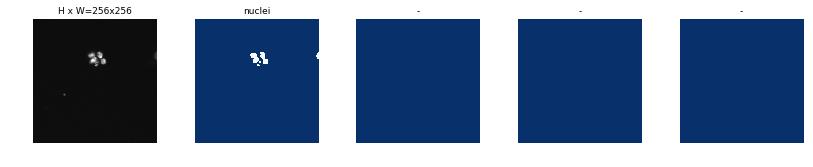

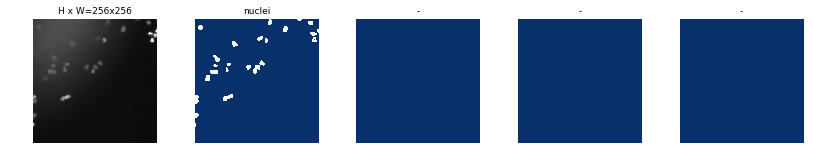

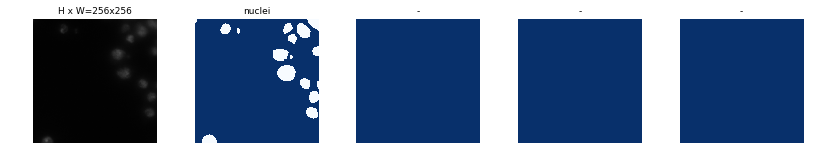

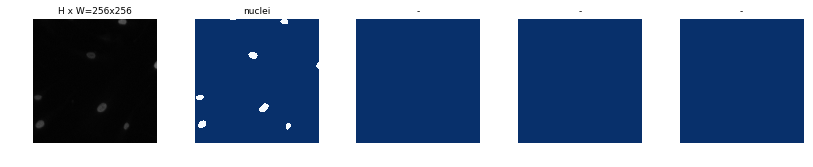

In [188]:
# Load and display random samples

image_ids = np.random.choice(dataset_train.image_ids, 4)
for image_id in image_ids:
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)


##Create model

In [197]:
# Create model in training mode
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)

In [198]:
# Which weights to start with? Used coco weights? 
init_with = "coco"  # imagenet, coco, or last

if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    # Load the last model you trained and continue training
    model.load_weights(model.find_last()[1], by_name=True)

##Training
Train in two stages:

Only the heads. Here we're freezing all the backbone layers and training only the randomly initialized layers (i.e. the ones that we didn't use pre-trained weights from MS COCO). To train only the head layers, pass layers='heads' to the train() function.

Fine-tune all layers. For this simple example it's not necessary, but we're including it to show the process. Simply pass layers="all to train all layers.

In [199]:
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE, 
            epochs=1, 
            layers='heads')


Starting at epoch 0. LR=0.001

Checkpoint Path: /Users/yzu280/Documents/kaggle/Kaggle2018/logs/nuclei20180312T1605/mask_rcnn_nuclei_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDis

ERROR:root:Error processing image {'id': 3, 'source': 'nuclei', 'path': './input/stage1_train/e81c758e1ca177b0942ecad62cf8d321ffc315376135bcbed3df932a6e5b40c0/images/e81c758e1ca177b0942ecad62cf8d321ffc315376135bcbed3df932a6e5b40c0.png', 'maskpath': './input/stage1_train/e81c758e1ca177b0942ecad62cf8d321ffc315376135bcbed3df932a6e5b40c0/masks/'}
Traceback (most recent call last):
  File "/Users/yzu280/Documents/kaggle/Kaggle2018/model.py", line 1698, in data_generator
    batch_images[b] = mold_image(image.astype(np.float32), config)
  File "/Users/yzu280/Documents/kaggle/Kaggle2018/model.py", line 2524, in mold_image
    return images.astype(np.float32) - config.MEAN_PIXEL
ValueError: operands could not be broadcast together with shapes (256,256,4) (3,) 


ERROR:root:Error processing image {'id': 4, 'source': 'nuclei', 'path': './input/stage1_train/797945873ca2a95f028671714b71eb3f883efe9dae7fcd3fc0ea1521efb73aaa/images/797945873ca2a95f028671714b71eb3f883efe9dae7fcd3fc0ea1521efb73aaa.png', 'maskpath': './input/stage1_train/797945873ca2a95f028671714b71eb3f883efe9dae7fcd3fc0ea1521efb73aaa/masks/'}
Traceback (most recent call last):
  File "/Users/yzu280/Documents/kaggle/Kaggle2018/model.py", line 1698, in data_generator
    batch_images[b] = mold_image(image.astype(np.float32), config)
  File "/Users/yzu280/Documents/kaggle/Kaggle2018/model.py", line 2524, in mold_image
    return images.astype(np.float32) - config.MEAN_PIXEL
ValueError: operands could not be broadcast together with shapes (256,256,4) (3,) 


ERROR:root:Error processing image {'id': 1, 'source': 'nuclei', 'path': './input/stage1_train/8a65e41c630d85c0004ce1772ff66fbc87aca34cb165f695255b39343fcfc832/images/8a65e41c630d85c0004ce1772ff66fbc87aca34cb165f695255b39343fcfc832.png', 'maskpath': './input/stage1_train/8a65e41c630d85c0004ce1772ff66fbc87aca34cb165f695255b39343fcfc832/masks/'}
Traceback (most recent call last):
  File "/Users/yzu280/Documents/kaggle/Kaggle2018/model.py", line 1698, in data_generator
    batch_images[b] = mold_image(image.astype(np.float32), config)
  File "/Users/yzu280/Documents/kaggle/Kaggle2018/model.py", line 2524, in mold_image
    return images.astype(np.float32) - config.MEAN_PIXEL
ValueError: operands could not be broadcast together with shapes (256,256,4) (3,) 


ERROR:root:Error processing image {'id': 0, 'source': 'nuclei', 'path': './input/stage1_train/6fe2df6de1d962b90146c822bcefc84d0d3d6926fdfbacd3acdc9de830ee5622/images/6fe2df6de1d962b90146c822bcefc84d0d3d6926fdfbacd3acdc9de830ee5622.png', 'maskpath': './input/stage1_train/6fe2df6de1d962b90146c822bcefc84d0d3d6926fdfbacd3acdc9de830ee5622/masks/'}
Traceback (most recent call last):
  File "/Users/yzu280/Documents/kaggle/Kaggle2018/model.py", line 1698, in data_generator
    batch_images[b] = mold_image(image.astype(np.float32), config)
  File "/Users/yzu280/Documents/kaggle/Kaggle2018/model.py", line 2524, in mold_image
    return images.astype(np.float32) - config.MEAN_PIXEL
ValueError: operands could not be broadcast together with shapes (256,256,4) (3,) 


ERROR:root:Error processing image {'id': 2, 'source': 'nuclei', 'path': './input/stage1_train/449fe932622db3b49366a260ddd20077219f96fb2dc0f912ad4f60b087876f3b/images/449fe932622db3b49366a260ddd20077219f96fb2dc0f912ad4f60b087876f3b.png', 'maskpath': './input/stage1_train/449fe932622db3b49366a260ddd20077219f96fb2dc0f912ad4f60b087876f3b/masks/'}
Traceback (most recent call last):
  File "/Users/yzu280/Documents/kaggle/Kaggle2018/model.py", line 1698, in data_generator
    batch_images[b] = mold_image(image.astype(np.float32), config)
  File "/Users/yzu280/Documents/kaggle/Kaggle2018/model.py", line 2524, in mold_image
    return images.astype(np.float32) - config.MEAN_PIXEL
ValueError: operands could not be broadcast together with shapes (256,256,4) (3,) 


ERROR:root:Error processing image {'id': 2, 'source': 'nuclei', 'path': './input/stage1_train/449fe932622db3b49366a260ddd20077219f96fb2dc0f912ad4f60b087876f3b/images/449fe932622db3b49366a260ddd20077219f96fb2dc0f912ad4f60b087876f3b.png', 'maskpath': './input/stage1_train/449fe932622db3b49366a260ddd20077219f96fb2dc0f912ad4f60b087876f3b/masks/'}
Traceback (most recent call last):
  File "/Users/yzu280/Documents/kaggle/Kaggle2018/model.py", line 1698, in data_generator
    batch_images[b] = mold_image(image.astype(np.float32), config)
  File "/Users/yzu280/Documents/kaggle/Kaggle2018/model.py", line 2524, in mold_image
    return images.astype(np.float32) - config.MEAN_PIXEL
ValueError: operands could not be broadcast together with shapes (256,256,4) (3,) 


ValueError: operands could not be broadcast together with shapes (256,256,4) (3,) 